# libraries

In [1]:
from nntool import unet
from utils.utilities import devtools
import os
import glob
import time
import joblib

import math
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from datetime import datetime


import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from glob import glob
from datetime import datetime
import subprocess
from tqdm import tqdm

from nntool import unet_h4

dtools = devtools()

In [2]:
from skimage import exposure
from skimage import img_as_float
from scipy import ndimage
from skimage.util import random_noise
import random
from pprint import pprint
# from dataflow import DataFlow
import warnings

import cv2
warnings.filterwarnings('ignore')

In [3]:
train_df = joblib.load("./picklefiles/thold__req_img_mask_df_train")
val_df = joblib.load("./picklefiles/thold__req_img_mask_df_val")

failed_train_df = joblib.load("./picklefiles/thold__not_req_img_mask_df_train")
failed_val_df = joblib.load("./picklefiles/thold__not_req_img_mask_df_val")

In [4]:
IMG_HEIGHT, IMG_WIDTH = 224, 224

# input parameters

In [5]:
class ImageOperations:
    
    def __init__(self,IMG_HEIGHT=256, IMG_WIDTH=256, as_gray=True, fit_op=True):
        self.img = None
        self.msk = None
        self.fit_op = fit_op
        self.IMG_HEIGHT, self.IMG_WIDTH = IMG_HEIGHT, IMG_WIDTH
        self.as_gray =as_gray
        
    ###################################
    ####### START of OPERATIONS #######
    ###################################

    def pass1(self, img_path, mask_path, IMG_HEIGHT, IMG_WIDTH, as_gray=True):
        self.img = io.imread(img_path, as_gray=as_gray)
        self.msk = io.imread(mask_path, as_gray=as_gray)

        img = resize(self.img, (self.IMG_HEIGHT, self.IMG_WIDTH))
        msk = resize(self.msk, (self.IMG_HEIGHT, self.IMG_WIDTH))

        
        
        msk = np.where(msk>0.5,1,0)
        
        self.img = img
        self.msk = msk

        IMG,MSK =  img, msk
        # print(IMG.shape, MSK.shape)
        if not self.fit_op:
            return IMG, MSK
        else:
            return IMG.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1), MSK.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)
    
    
    def contrast_adjust(self, img, msk):
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        
        IMG,MSK =  img, msk
        if not self.fit_op:
            return IMG, MSK
        else:
            return IMG.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1), MSK.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)
    
    
    def histogram_equalization(self, img, msk):
        img = exposure.equalize_hist(img)
        # img = exposure.equalize_adapthist(img, clip_limit=0.03) <<<< does NOT work
        
        # contrast limited adaptive hist equalization
        # clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
        # img = clahe.apply(img)
        
        
        
        IMG,MSK =  img, msk
        if not self.fit_op:
            return IMG, MSK
        else:
            return IMG.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1), MSK.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)
    

    def horizontal_flip_op(self, img, msk):
        
        IMG,MSK =  np.fliplr(img), np.fliplr(msk)
        if not self.fit_op:
            return IMG, MSK
        else:
            return IMG.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1), MSK.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)

    def vertical_flip_op(self, img, msk):
        
        IMG,MSK =  np.flipud(img), np.flipud(msk)
        if not self.fit_op:
            return IMG, MSK
        else:
            return IMG.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1), MSK.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)

    def rotation_op(self, img, msk, rotation_range):
        r = np.random.randint(low=-rotation_range, high=rotation_range)

        
        IMG,MSK =  rotate(img, r), rotate(msk, r)
        if not self.fit_op:
            return IMG, MSK
        else:
            return IMG.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1), MSK.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)
    
    
    def center_crop_op(self, img, cropx, cropy):
        # print(img.shape)
        y,x = img.shape
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)    
        return img[starty:starty+cropy,startx:startx+cropx]
    
    def zoom_op(self, img, msk, zoom_range=3):
        r = random.uniform(1,zoom_range)
        
        img, msk = np.squeeze(img), np.squeeze(msk)
        
        img = ndimage.zoom(img,r)
        msk = ndimage.zoom(msk,r)
        
        img = self.center_crop_op(img, self.IMG_HEIGHT, self.IMG_WIDTH)
        msk = self.center_crop_op(msk, self.IMG_HEIGHT, self.IMG_WIDTH)
        img, msk = resize(img, (self.IMG_HEIGHT, self.IMG_WIDTH)), resize(msk, (self.IMG_HEIGHT, self.IMG_WIDTH))
        
        
        # do min max scaling of mask and image
        # as values of pixels goes above 1 and below 0 sometimes
        
        img = (img - np.min(img.flatten()))/(np.max(img.flatten()) - np.min(img.flatten()))
        msk = (msk - np.min(msk.flatten()))/(np.max(msk.flatten()) - np.min(msk.flatten()))
        
        
        IMG, MSK = img, msk
        
        
        if not self.fit_op:
            return IMG, MSK
        else:
            return IMG.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1), MSK.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)
    

        
    def gamma_op(self, img, msk):
        adjusted_gamma_img = exposure.adjust_gamma(img, gamma=0.4, gain=0.9)
        
        IMG,MSK = adjusted_gamma_img, msk
        if not self.fit_op:
            return IMG, MSK
        else:
            return IMG.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1), MSK.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)

    def blur_op(self, img, msk):
        # print(img.shape)
        blured_img = ndimage.uniform_filter(img, size=(3, 3, 1))
        blured_msk = msk  # don't blur the mask
        
        IMG,MSK =  (blured_img, blured_msk)
        if not self.fit_op:
            return IMG, MSK
        else:
            return IMG.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1), MSK.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)

    def gaussian_noise(self, img, msk):
        
        IMG,MSK =  random_noise(img), msk
        if not self.fit_op:
            return IMG, MSK
        else:
            return IMG.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1), MSK.reshape(self.IMG_HEIGHT, self.IMG_WIDTH, 1)


    ###################################
    ######### END of OPERATIONS #######
    ###################################


<Figure size 432x288 with 0 Axes>

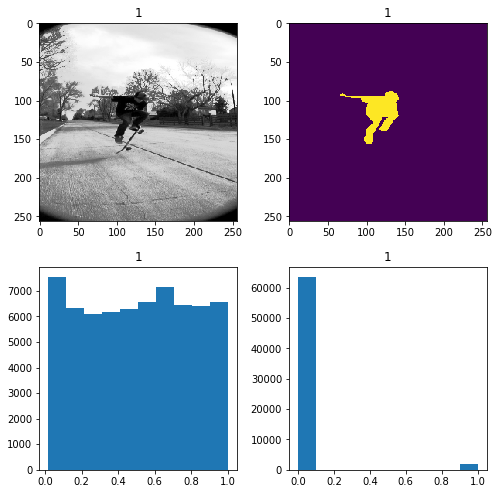

<Figure size 432x288 with 0 Axes>

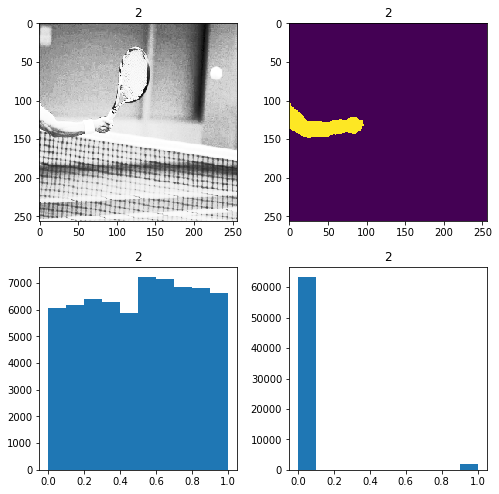

<Figure size 432x288 with 0 Axes>

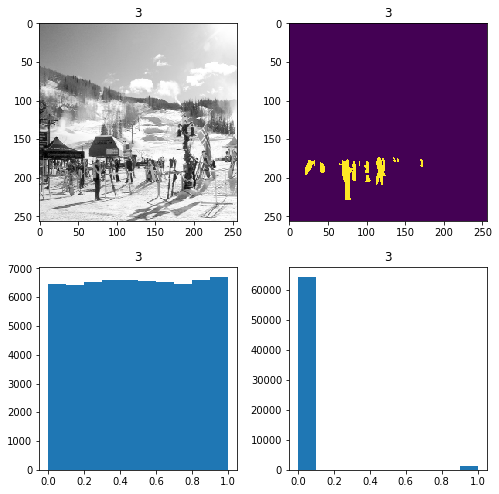

<Figure size 432x288 with 0 Axes>

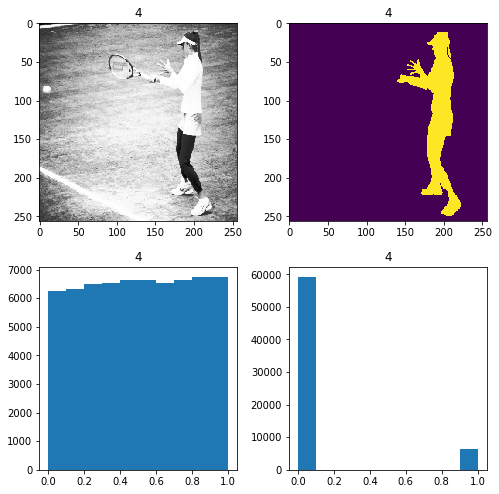

<Figure size 432x288 with 0 Axes>

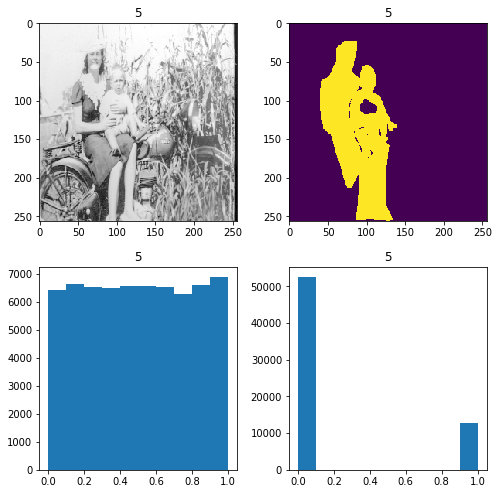

<Figure size 432x288 with 0 Axes>

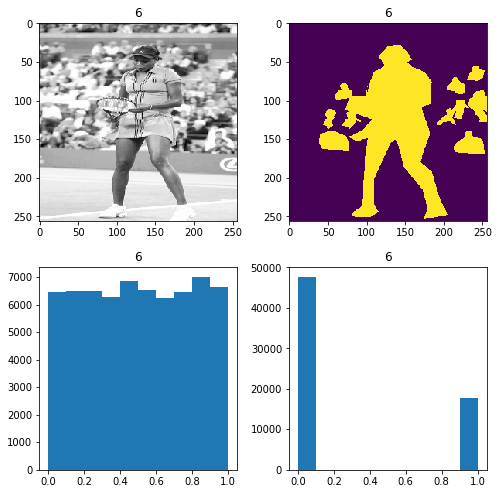

<Figure size 432x288 with 0 Axes>

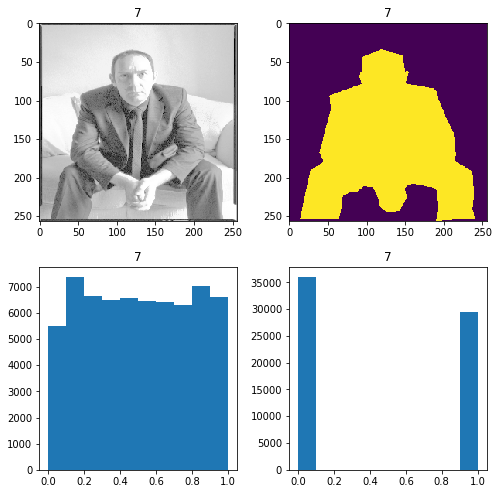

In [14]:
imop_ob = ImageOperations()


for e,i in enumerate(train_df.values[5688:5695]):
    # im,ms = next(g_train)
    x,y = i
    x_,y_ = imop_ob.pass1(x,y, IMG_HEIGHT, IMG_WIDTH)
    
    x_,y_ = imop_ob.histogram_equalization(x_, y_)
    x__, y__ = imop_ob.gamma_op(x_, y_)
    
    plt.figure()
    f, ax = plt.subplots(2,2,figsize=(7,7))

    ax[0,0].title.set_text(str(e+1))
    ax[0,0].imshow(np.squeeze(x__),cmap='gray')

    ax[0,1].title.set_text(str(e+1))
    ax[0,1].imshow(np.squeeze(y__))

    ax[1,0].title.set_text(str(e+1))
    ax[1,0].hist(x_.flatten())

    ax[1,1].title.set_text(str(e+1))
    ax[1,1].hist(y_.flatten())

    plt.tight_layout()

(array([12940.,  5693.,  5393.,  5983.,  6338.,  6307.,  6332.,  6186.,
         5103.,  5261.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

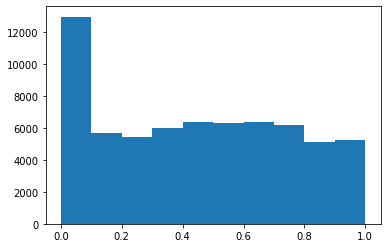

In [7]:
plt.hist(x__.flatten())

(array([ 7604.,     0.,     0., 12728.,   250.,   243.,   255.,   238.,
          291., 43927.]),
 array([0.00000000e+00, 1.62630326e-20, 3.25260652e-20, 4.87890978e-20,
        6.50521303e-20, 8.13151629e-20, 9.75781955e-20, 1.13841228e-19,
        1.30104261e-19, 1.46367293e-19, 1.62630326e-19]),
 <a list of 10 Patch objects>)

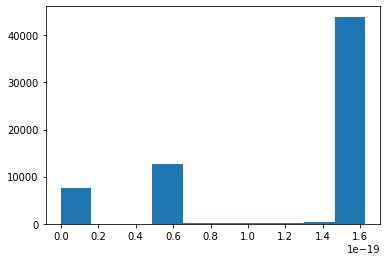

In [8]:
plt.hist(y__.flatten())